## Uso de las vecotores con algoritmo de KNN 

In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.color import rgb2gray
import json
import matplotlib.pyplot as plt

def load_features(output_dir):
    """
    Carga descriptores y mapeo desde archivos
    """
    descriptors = np.load(f"{output_dir}/descriptores.npy")
    with open(f"{output_dir}/checkpoint.json", 'r') as f:
        mapping = json.load(f)
    return descriptors, mapping


output_dir = "features15k"
descriptors, mapping = load_features(output_dir)


In [2]:
print("Descriptores cargados:")
print(f"- Total descriptores: {descriptors.shape[0]}")
print(f"- Dimensiones descriptores: {descriptors.shape[1]}")
print(f"- Mapeo de imágenes: {len(mapping)}")


Descriptores cargados:
- Total descriptores: 15019
- Dimensiones descriptores: 128
- Mapeo de imágenes: 15019


## Uso de KNN

In [3]:
from collections import defaultdict
import matplotlib.pyplot as plt
from rtree import index
import numpy as np

# Métrica de distancia: Euclidiana
def euclidean_distance(P, Q):
    return np.sqrt(np.sum((P - Q) ** 2))

def create_rtree_index(descriptors):
    p = index.Property()
    p.dimension = 128  # Dimensión de los embeddings faciales
    idx = index.Index(properties=p)
    
    for i, descriptor in enumerate(descriptors):
        # Usamos cada dimensión como límite inferior y superior
        idx.insert(i, tuple(descriptor) + tuple(descriptor))
    return idx


# Búsqueda KNN usando R-Tree
def knn_rtree(query_vector, idx, descriptors, k=5):
    # Buscamos en el índice
    nearest_neighbors = list(idx.nearest(tuple(query_vector) + tuple(query_vector), k))
    # Retornamos los vecinos con sus distancias calculadas
    return [(i, euclidean_distance(query_vector, descriptors[i])) for i in nearest_neighbors]


In [4]:
def show_results(results, json_path= output_dir + "/image_mapping.json", query_idx=None, num_results=5):
    """
    Muestra imagen de consulta y resultados usando el mapping de imágenes
    """
    # Leer archivo de mapping
    with open(json_path, 'r') as f:
        image_mapping = json.load(f)
    
    n_imgs = min(len(results), num_results)
    
    # Calcular disposición de la matriz
    if n_imgs > 5:
        n_cols = 5
        n_rows = (n_imgs - 1) // n_cols + 1
        fig = plt.figure(figsize=(15, 3*n_rows))
    else:
        fig = plt.figure(figsize=(15, 5))
    
    try:
        # Obtener información de la imagen de consulta
        query_info = image_mapping[str(query_idx)]
        query_url = query_info['link']
        query_filename = query_info['filename']
        query_img = imread(query_url)
        
        # Mostrar imagen de consulta
        if n_imgs > 5:
            plt.subplot(n_rows + 1, n_cols, 3)
        else:
            plt.subplot(1, n_imgs + 1, 1)
        
        # Agregar borde rojo
        plt.imshow(query_img)
        plt.gca().spines['bottom'].set_color('red')
        plt.gca().spines['top'].set_color('red')
        plt.gca().spines['left'].set_color('red')
        plt.gca().spines['right'].set_color('red')
        plt.gca().spines['bottom'].set_linewidth(5)
        plt.gca().spines['top'].set_linewidth(5)
        plt.gca().spines['left'].set_linewidth(5)
        plt.gca().spines['right'].set_linewidth(5)
        
        plt.title(f"Consulta:\n{query_filename}", fontsize=10)
        plt.axis('on')
        plt.xticks([])
        plt.yticks([])
        
        # Mostrar resultados
        for i, (idx, distance) in enumerate(results[:num_results]):
            try:
                # Obtener información del resultado desde el mapping
                result_info = image_mapping[str(idx)]
                image_url = result_info['link']
                filename = result_info['filename']
                img = imread(image_url)
                
                if n_imgs > 5:
                    plt.subplot(n_rows + 1, n_cols, n_cols + i + 1)
                else:
                    plt.subplot(1, n_imgs + 1, i + 2)
                
                plt.imshow(img)
                plt.title(f"Resultado {i+1}:\n{filename}\nDist: {distance:.4f}", fontsize=10)
                plt.axis('off')
                
            except Exception as e:
                print(f"Error mostrando resultado {idx}: {e}")
    
    except Exception as e:
        print(f"Error mostrando imagen de consulta: {e}")
    
    plt.tight_layout()
    plt.show()

7136
rtree.index.Index(bounds=[0.9888888597488403, 2.2666666507720947, 0.6936706900596619, 0.3636363744735718, 0.2238806039094925, 0.15068493783473969, 0.1538461595773697, 0.0, 12.861734390258789, 7.572193622589111, 0.6974616646766663, 0.14552238583564758, 0.25342464447021484, 0.006849315017461777, 0.006849315017461777, 0.7142857313156128, 17.77193832397461, 5.545551300048828, 0.30067113041877747, 0.0, 0.0, 0.0, 0.0, 0.2857142984867096, 8.207653045654297, 0.8805969953536987, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4285714328289032, 1.355555534362793, 2.0999999046325684, 0.7298499941825867, 0.560606062412262, 0.4514925479888916, 0.5675675868988037, 0.5231481194496155, 0.7142857313156128, 21.87550926208496, 7.739492416381836, 0.8239657282829285, 0.0595238097012043, 0.3221476376056671, 0.027397260069847107, 0.5835668444633484, 5.4285712242126465, 24.989980697631836, 5.852174282073975, 0.519463062286377, 0.011904762126505375, 0.013698630034923553, 0.0, 0.0, 7.009068965911865, 13.634267807006836, 1.7164

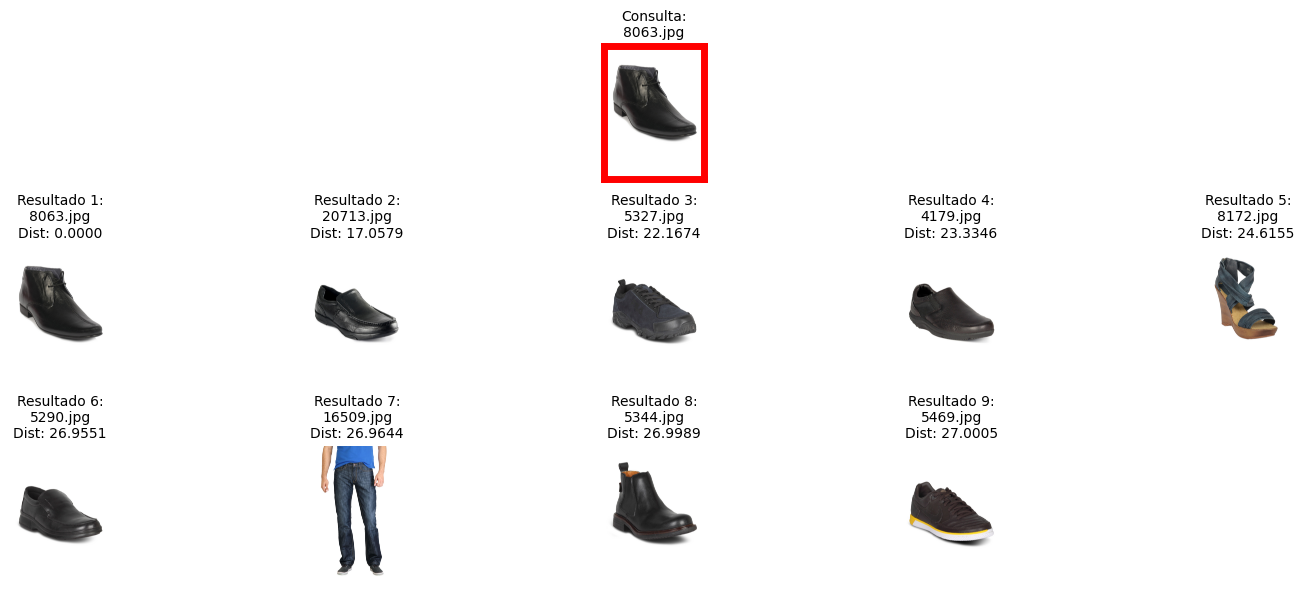

In [5]:
# Imagen aleatoria del dataset
random = np.random.randint(len(descriptors))
# random = 7
print(random)
query_vector = descriptors[random]

k = 9
idx = create_rtree_index(descriptors)
rtree_result = knn_rtree(query_vector, idx, descriptors, k=k)

print(idx)
print(rtree_result)

show_results(results=rtree_result, json_path= output_dir +  "/image_mapping.json", query_idx=random, num_results=k)




### NO ejecutar está parte si está provando el KNN, esta parte es para organizar los indices


In [6]:
import json
import pandas as pd

def get_image_by_index(index, checkpoint_path= output_dir + "/checkpoint.json", csv_path="images.csv"):
    """
    Obtiene el nombre y link de la imagen dado su índice
    
    Args:
        index (int): Índice del vector de características
        checkpoint_path (str): Ruta al archivo checkpoint.json
        csv_path (str): Ruta al archivo images.csv
        
    Returns:
        tuple: (nombre_imagen, link_imagen) o (None, None) si no existe
    """
    # Leer checkpoint
    with open(checkpoint_path, 'r') as f:
        checkpoint = json.load(f)
    
    # Invertir el diccionario para buscar por índice
    index_to_image = {v: k for k, v in checkpoint.items()}
    
    # Obtener nombre de imagen del índice
    image_name = index_to_image.get(index)
    if not image_name:
        return None, None
        
    # Buscar en CSV
    df = pd.read_csv(csv_path)
    image_data = df[df['filename'] == image_name]
    
    if image_data.empty:
        return None, None
        
    return image_name, image_data.iloc[0]['link']

# # Ejemplo de uso:
# nombre, link = get_image_by_index(0)
# print(f"Nombre: {nombre}")
# print(f"Link: {link}")

In [7]:
def save_image_mapping(output_path= output_dir + "/image_mapping.json", checkpoint_path= output_dir +  "/checkpoint.json", csv_path="images.csv"):
    """
    Crea un JSON con mapeo de índices, nombres y links verificados
    
    Args:
        output_path (str): Ruta donde guardar el nuevo JSON
        checkpoint_path (str): Ruta del checkpoint.json
        csv_path (str): Ruta del CSV con links
    """
    # Leer checkpoint y CSV
    with open(checkpoint_path, 'r') as f:
        checkpoint = json.load(f)
    
    df = pd.read_csv(csv_path)
    
    # Crear nuevo diccionario con la información completa
    image_mapping = {}
    
    for image_name, vector_index in checkpoint.items():
        # Buscar link en CSV
        image_data = df[df['filename'] == image_name]
        
        if not image_data.empty:
            link = image_data.iloc[0]['link']
            image_mapping[vector_index] = {
                'filename': image_name,
                'link': link
            }
        else:
            print(f"Advertencia: No se encontró link para {image_name}")
    
    # Guardar el nuevo mapping
    with open(output_path, 'w') as f:
        json.dump(image_mapping, f, indent=4)
    
    print(f"Mapping guardado en {output_path}")
    print(f"Total de imágenes mapeadas: {len(image_mapping)}")

# # Ejemplo de uso:
# save_image_mapping()